In [1]:
# Load the necessary Python packages for the analysis.
import datacube
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterstats import zonal_stats
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


In [2]:
# Set important parameters for the analysis.

# File path to the validation dataset. 
validation_data_fp = "data/ceo-LULC-monitoring-in-Tunisia-sample-data-2022-11-11.csv"
# Load a reclassified LULC image from the 01_LULC_Tunisia notebook.
image_fp = "results/2019_Tunisia_reclassified_lulc.tif"
# Statistic to use to sample the reclassified LULC image.
stats = "mean"

# Define the labels and class values of the aggregated land use land cover classes.
lulc_labels = ["Treed areas", "Prairies", "Cultivated land", "Wetlands", "Artificial surfaces", "Other land", "Water bodies"]
lulc_classes = [1, 2, 3, 4, 5, 6, 7]
# Map the LULC class labels to the class values.
lulc_class_dict = dict(zip(lulc_labels, lulc_classes))

In [3]:
# Load the reclassified image.
image = xr.open_dataarray(image_fp).squeeze()

# Get the affine transform of the image. 
affine = image.geobox.affine

# Get the crs of the image.
crs = image.geobox.crs

# Convert the xarray.DataArray to a numpy array.
image_array = image.values

In [4]:
# Load the validation dataset as a pandas DataFrame.
validation_data_df = pd.read_csv(validation_data_fp)

# Convert the pandas DataFrame to a geopandas GeoDataFrame. 
validation_data_gdf = gpd.GeoDataFrame(validation_data_df, geometry=gpd.points_from_xy(validation_data_df.lon, validation_data_df.lat), crs="EPSG:4326")

# Select the columns to use from the dataset.
validation_data_gdf = validation_data_gdf[["Class","geometry"]]

# Remap the values for the LULC classes. 
validation_data_gdf["actual"] = validation_data_gdf["Class"].map(lulc_class_dict)

# Reproject the validation data to the same crs as the image.
validation_data_gdf = validation_data_gdf.to_crs(crs)

In [5]:
# View the coverage of the validation dataset.
validation_data_gdf.explore()

In [6]:
# Sample the image using the validation_data_gdf points. 
predicted = zonal_stats(validation_data_gdf, image_array, affine=affine, stats=[stats], nodata=np.nan)
# Add the predicted values to the validation_data_gdf. 
validation_data_gdf["predicted"] = [predicted_value[stats] for predicted_value in predicted]

In [7]:
# Drop rows if there is no "actual" or "predicted" value assigned to the sample point. 
validation_data_gdf = validation_data_gdf.dropna()

In [8]:
y_true = validation_data_gdf["actual"].values 
y_pred = validation_data_gdf["predicted"].values

In [9]:
overall_accuracy = accuracy_score(y_true, y_pred) * 100
f1score = f1_score(y_true, y_pred, average="macro")
precision = precision_score(y_true, y_pred, average="macro", zero_division=0) * 100
recall = recall_score(y_true, y_pred, average="macro", zero_division=0) * 100

In [10]:
print("\033[1m" + "\033[91m" + "LULC Reclassification Results")  # bold print and red
print("\033[0m")  # stop bold and red
print(f"Overall Accuracy: {round(overall_accuracy, 2)}%")
print(f"F1 score: \t {round(f1score, 2)}")
print(f"Producer's Accuracy: {round(precision, 2)}%")
print(f"User's Accuracy: {round(recall, 2)}%")

LULC Reclassification Results

Overall Accuracy: 68.13%
F1 score: 	 0.33
Producer's Accuracy: 44.45%
User's Accuracy: 31.28%


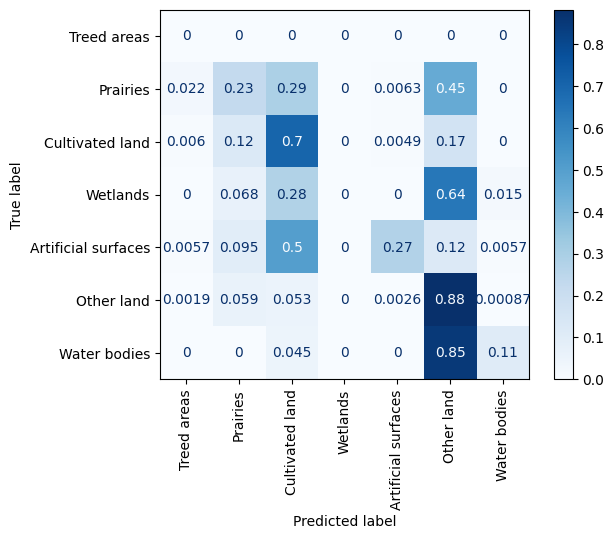

In [11]:
# Plot the confusion matrix for the predictions. 
ConfusionMatrixDisplay.from_predictions(y_true, 
                                        y_pred,
                                        labels=lulc_classes,
                                        normalize="true",
                                        display_labels=lulc_labels,
                                        xticks_rotation="vertical",
                                        cmap=plt.cm.Blues
                                       );